<a href="https://colab.research.google.com/github/mjkellykim/GANinAction/blob/main/ch3_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**3.4.1 모듈 임포트와 모델 입력 차원 설정**

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels) # 입력 이미지 차원

z_dim = 100 # 생성자의 입력으로 사용될 잡음 벡터의 크기

**3.4.2 생성자 구현**

In [ ]:
# Generator
def build_generator(img_shape, z_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=z_dim)) # 완전 연결층
    model.add(LeakyReLU(alpha=0.01)) # LeakyReLU 활성화 함수
    #일반적인 ReLU와 달리 작은 기울기를 사용하여 훈련중 gradient가 사라지는 것을 막아 훈련 결과를 향상
    model.add(Dense(28*28*1, activation='tanh')) # tanh 활성화 함수를 사용한 출력층
    # tanh는 0~1범위인 sigmoid보다 보다 또렷한 이미지를 만듦
    model.add(Reshape(img_shape)) # 생성자 출력을 이미지 차원으로 변경
    return model

**3.4.3 판별자 구현**
대부분의 GAN은 생성자와 판별자 네트워크 구조는 크기와 구조가 매우 다름


In [ ]:
# Discriminator
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape)) # 입력 이미지 일렬로 펼치기
    model.add(Dense(128)) # 완전 연결층
    model.add(LeakyReLU(alpha=0.01)) # LeakyReLU 활성화 함수
    model.add(Dense(1,activation='sigmoid')) # sigmoid 활성화 함수를 사용한 출력층
    #여기서 sigmoid 함수를 사용한 이유는 출력값을 0과 1로 만들기 때문에 
    #판별자가 입력을 진짜로 생각하는 확률로 해석할 수 있음
    return model

**3.4.4 모델 생성**

In [ ]:
# Build the GAN Model
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [ ]:
discriminator = build_discriminator(img_shape) # 판별자 모델 만들고 컴파일 하기
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])
# 이진 교차 엔트로피를 훈련하는 동안 손실 함수로 사용
# 두 개의 클래스만 있는 예측에서 계산된 확률과 진짜 확률 사이의 차이를 측정
# 교차 엔트로피 손실이 클수록 예측이 정답 레이블과 차이가 큼

generator = build_generator(img_shape, z_dim) # 생성자 모델 만들기

discriminator.trainable = False # 생성자 훈련시에 판별자 파라미터 동결
 
gan = build_gan(generator, discriminator) # 생성자를 훈련하기 위해 동결한 판별자로 GAN 모델 만들고 컴파일하기
gan.compile(loss='binary_crossentropy', optimizer=Adam())
# Adam optimization algorithm => 적응적 모멘트 추정(adaptive moment estimation)에서 따온 것으로 
# 고급 경사 하강법 기반의 옵티마이저
# 뛰어난 성능으로 Adam이 대부분의 GAN 구현의 기본 옵티마이저임!

**3.4.5 훈련**

In [ ]:
# Training
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    
    (X_train, _), (_, _) = mnist.load_data() # 데이터셋 로드

    X_train = X_train / 127.5 - 1.0 # [0, 255] 흑백 픽셀값을 [-1, 1] 사이로 스케일 조정
    X_train = np.expand_dims(X_train, axis=3)

    # 원-핫(one-hot) 인코딩된 레이블 사용!
    real = np.ones((batch_size, 1)) # 진짜 이미지 레이블 : 모두 1
    fake = np.zeros((batch_size, 1)) # 가짜 이미지 레이블 : 모두 0

    for iteration in range(iterations):
        idx = np.random.randint(0, X_train.shape[0], batch_size) # 진짜 이미지에서 랜덤 배치 가져오기
        imgs = X_train[idx]
     
        #### 판별자 훈련 시작
        z = np.random.normal(0, 1, (batch_size, 100)) # 가짜 이미지 배치 생성
        # 준정규분포(평균=0, 표준편차=1인 종모양 곡선)에서 샘플링하여 z벡터 생성
        gen_imgs = generator.predict(z) ## kmjeung

        d_loss_real = discriminator.train_on_batch(imgs, real) # 판별자 훈련
        d_loss_fake = discriminator.train_on_batch(gen_imgs ,fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        #### 생성자 훈련 시작
        z = np.random.normal(0, 1, (batch_size, 100)) # 가짜 이미지 배치 생성
        gen_imgs = generator.predict(z)

        g_loss = gan.train_on_batch(z, real) # 생성자 훈련

        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss,g_loss)) # 훈련 후 그래프를 그리기 위한 손실과 정확도 저장
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)
            print("%d [D 손실: %f, 정확도: %.2f%%] [G 손실: %f]" % # 훈련 과정 출력
                  (iteration+1, d_loss, 100.0 * accuracy, g_loss))
            
            sample_images(generator)

**3.4.6 샘플 이미지 출력**

In [ ]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    gen_imgs = generator.predict(z) # 랜덤한 잡음에서 이미지 생성

    gen_imgs = 0.5 * gen_imgs + 0.5 # 이미지 픽셀 값을 [0,1] 범위로 스케일 조정

    fig, axs = plt.subplots(image_grid_rows, # 이미지 그리드 설정
                            image_grid_columns, 
                            figsize=(4,4),
                            sharey=True,
                            sharex=True)
    
    cnt = 0
    for i in range(image_grid_columns):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray') # 이미지 그리드 출력
            axs[i, j].axis('off')
            cnt += 1

**3.4.7 모델 실행**

11501568/11490434 [==============================] - 0s 0us/step
1000 [D 손실: 0.004528, 정확도: 100.00%] [G 손실: 6.315844]
2000 [D 손실: 0.026937, 정확도: 99.22%] [G 손실: 5.472832]
3000 [D 손실: 0.124372, 정확도: 96.09%] [G 손실: 5.648935]
4000 [D 손실: 0.114656, 정확도: 94.53%] [G 손실: 5.917837]
5000 [D 손실: 0.189961, 정확도: 93.75%] [G 손실: 4.115126]
6000 [D 손실: 0.342823, 정확도: 87.50%] [G 손실: 3.980030]
7000 [D 손실: 0.457872, 정확도: 78.91%] [G 손실: 3.051496]
8000 [D 손실: 0.366705, 정확도: 86.72%] [G 손실: 2.907197]
9000 [D 손실: 0.488172, 정확도: 77.73%] [G 손실: 2.896125]
10000 [D 손실: 0.281958, 정확도: 85.94%] [G 손실: 3.386284]
11000 [D 손실: 0.395980, 정확도: 84.77%] [G 손실: 3.420550]
12000 [D 손실: 0.309564, 정확도: 87.89%] [G 손실: 2.491826]
13000 [D 손실: 0.410230, 정확도: 82.03%] [G 손실: 2.677018]
14000 [D 손실: 0.521421, 정확도: 76.17%] [G 손실: 2.570168]
15000 [D 손실: 0.447951, 정확도: 80.86%] [G 손실: 2.646468]
16000 [D 손실: 0.295664, 정확도: 86.33%] [G 손실: 3.022172]
17000 [D 손실: 0.305261, 정확도: 85.94%] [G 손실: 3.329226]
18000 [D 손실: 0.284013, 정확도: 87.50%] [G 손실:

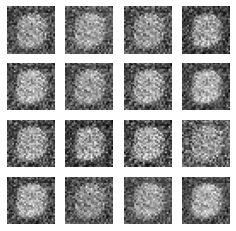

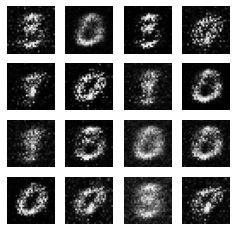

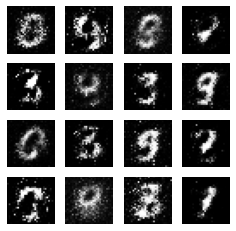

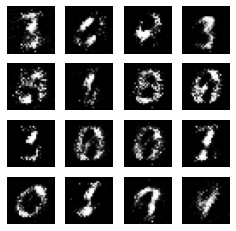

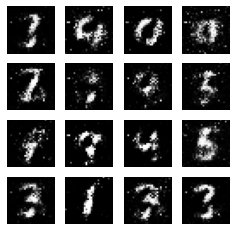

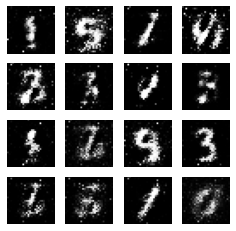

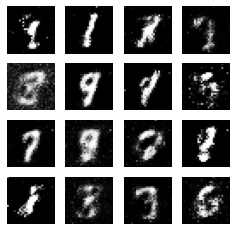

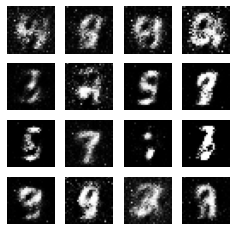

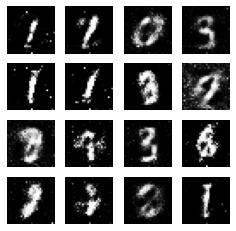

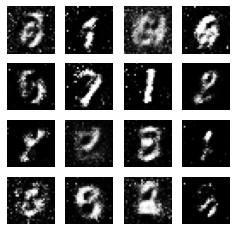

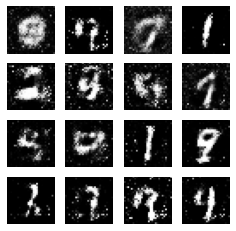

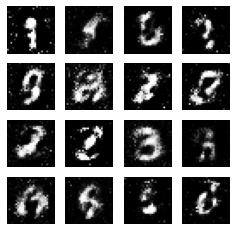

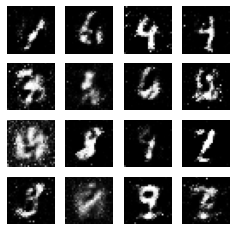

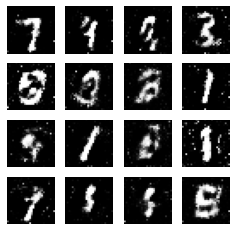

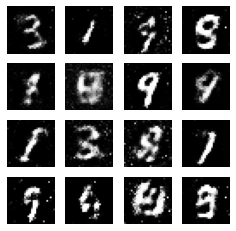

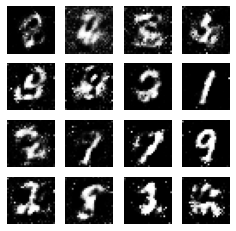

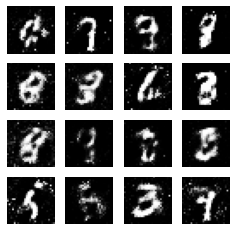

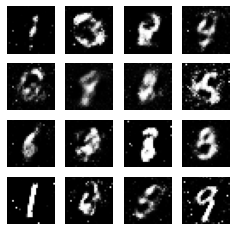

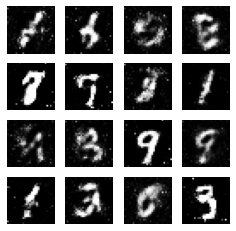

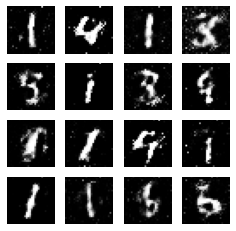

In [ ]:
iterations = 20000 # 하이퍼파라미터 설정
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval) # 지정된 횟수 동안 GAN 훈련